In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from torch.utils.data import random_split

from model.alexnet import AlexNet
from model.autoencoder import Autoencoder
from utils.dataset import DatasetFashion

In [3]:
EPOCHS = 5
BATCH_SIZE = 128
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

classes_labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
    ]

print(torch.__version__)
print(DEVICE)

2.1.2
cpu


In [4]:
Transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

### Эксперимент 1
Обучение на 100% выборки

In [4]:
train_csv = pd.read_csv('data/fashion/fashion-mnist_train.csv')
test_dataset = pd.read_csv('data/fashion/fashion-mnist_test.csv')

# train_csv = train_csv[0:3000]
# test_dataset = test_dataset[0:500]

train_dataset = train_csv.sample(frac = 0.8)
validation_dataset = train_csv.drop(train_dataset.index)

print(train_dataset.shape)
print(validation_dataset.shape)
print(test_dataset.shape)

(48000, 785)
(12000, 785)
(10000, 785)


In [5]:
train_loader = DataLoader(DatasetFashion(train_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(DatasetFashion(validation_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(DatasetFashion(test_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)

In [6]:
criterion = F.nll_loss

In [7]:
feature_extr_model = Autoencoder().to(DEVICE)
feature_extr_criterion = nn.MSELoss()
feature_extr_optimizer = torch.optim.AdamW(feature_extr_model.parameters())

In [7]:
feature_extr_model = Autoencoder()
feature_extr_model.load_state_dict(torch.load("./weights.pt"))
feature_extr_model.state_dict()

OrderedDict([('encoder.block1.conv1.weight',
              tensor([[[[-0.1834,  0.1030,  0.0168],
                        [-0.0739, -0.0884,  0.1383],
                        [-0.3070, -0.1014,  0.0966]]],
              
              
                      [[[ 0.3062, -0.2358, -0.3101],
                        [-0.0989, -0.2012,  0.1274],
                        [ 0.0905,  0.2455,  0.1862]]],
              
              
                      [[[ 0.2504,  0.2929, -0.1159],
                        [-0.2283,  0.1655, -0.0071],
                        [-0.1222, -0.2217, -0.2849]]],
              
              
                      [[[-0.1697, -0.3123,  0.1276],
                        [ 0.0783,  0.2056, -0.1198],
                        [ 0.3185,  0.1919,  0.0923]]],
              
              
                      [[[ 0.1347, -0.1281, -0.1534],
                        [-0.0119,  0.2101,  0.1783],
                        [ 0.1050,  0.1215, -0.1700]]],
              
              


In [10]:
def train_encoder(train_loader, epoch, train_losses):
    feature_extr_model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        output = feature_extr_model(data)
        loss = feature_extr_criterion(output, data)
        feature_extr_optimizer.zero_grad()
        loss.backward()
        feature_extr_optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.9f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [9]:
def test_encoder(validation_loader, validation_losses):
    feature_extr_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (data, _) in validation_loader:
            data = data.to(DEVICE)
            output = feature_extr_model(data)
            test_loss += feature_extr_criterion(output, data).item()
            pred = output.max(1, keepdim=True)[1]

        test_loss /= len(validation_loader)  
        validation_losses.append(test_loss)
        print("Validation set: Average loss: {:.9f}\n".format(test_loss))
        print('='*50)

In [10]:
# Обучение энкодера на 100% данных

encoder_train_losses = []
encoder_validation_losses = []

for epoch in range(1, EPOCHS+1):
    train_encoder(train_loader, epoch, encoder_train_losses)
    test_encoder(validation_loader, encoder_validation_losses)

Epoch:1 [3712/48000 (8%)]	Loss: 0.096564434
Epoch:1 [7552/48000 (16%)]	Loss: 0.015434095
Epoch:1 [11392/48000 (24%)]	Loss: 0.007866566
Epoch:1 [15232/48000 (32%)]	Loss: 0.005328527
Epoch:1 [19072/48000 (40%)]	Loss: 0.003834194
Epoch:1 [22912/48000 (48%)]	Loss: 0.004337605
Epoch:1 [26752/48000 (56%)]	Loss: 0.003096916
Epoch:1 [30592/48000 (64%)]	Loss: 0.002379427
Epoch:1 [34432/48000 (72%)]	Loss: 0.002042915
Epoch:1 [38272/48000 (80%)]	Loss: 0.001984346
Epoch:1 [42112/48000 (88%)]	Loss: 0.002848082
Epoch:1 [45952/48000 (96%)]	Loss: 0.001951471
Validation set: Average loss: 0.001991367

Epoch:2 [3712/48000 (8%)]	Loss: 0.001360684
Epoch:2 [7552/48000 (16%)]	Loss: 0.002638904
Epoch:2 [11392/48000 (24%)]	Loss: 0.001675588
Epoch:2 [15232/48000 (32%)]	Loss: 0.001313381
Epoch:2 [19072/48000 (40%)]	Loss: 0.001201023
Epoch:2 [22912/48000 (48%)]	Loss: 0.001020916
Epoch:2 [26752/48000 (56%)]	Loss: 0.000888105
Epoch:2 [30592/48000 (64%)]	Loss: 0.001381246
Epoch:2 [34432/48000 (72%)]	Loss: 0.0023741

In [8]:
encoder = feature_extr_model.encoder

In [9]:
def train(model, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def test(model, validation_loader, validation_losses, validation_accuracy):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(validation_loader.dataset)  
        validation_losses.append(test_loss)
        validation_accuracy.append(100. * correct / len(validation_loader.dataset))
        print("Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(validation_loader.dataset), 100. * correct / len(validation_loader.dataset)))
        print('='*50)

In [11]:
train_losses = []
validation_losses = []
validation_accuracy = []

model = AlexNet(encoder).to(DEVICE)
for param in model.encoder.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.parameters())

for epoch in range(1, EPOCHS * 2 + 1):
    train(model, train_loader, optimizer, epoch, train_losses)
    test(model, validation_loader, validation_losses, validation_accuracy)

Epoch:1 [3712/48000 (8%)]	Loss: 1.629991
Epoch:1 [7552/48000 (16%)]	Loss: 1.064424
Epoch:1 [11392/48000 (24%)]	Loss: 0.754155
Epoch:1 [15232/48000 (32%)]	Loss: 0.649315
Epoch:1 [19072/48000 (40%)]	Loss: 0.639616
Epoch:1 [22912/48000 (48%)]	Loss: 0.478132
Epoch:1 [26752/48000 (56%)]	Loss: 0.464294
Epoch:1 [30592/48000 (64%)]	Loss: 0.469970
Epoch:1 [34432/48000 (72%)]	Loss: 0.519059
Epoch:1 [38272/48000 (80%)]	Loss: 0.474233
Epoch:1 [42112/48000 (88%)]	Loss: 0.523594
Epoch:1 [45952/48000 (96%)]	Loss: 0.411043
Validation set: Average loss: 0.4323, Accuracy: 10041/12000 (84%)

Epoch:2 [3712/48000 (8%)]	Loss: 0.343417
Epoch:2 [7552/48000 (16%)]	Loss: 0.313471
Epoch:2 [11392/48000 (24%)]	Loss: 0.328430
Epoch:2 [15232/48000 (32%)]	Loss: 0.347130
Epoch:2 [19072/48000 (40%)]	Loss: 0.391066
Epoch:2 [22912/48000 (48%)]	Loss: 0.266928
Epoch:2 [26752/48000 (56%)]	Loss: 0.474290
Epoch:2 [30592/48000 (64%)]	Loss: 0.383880
Epoch:2 [34432/48000 (72%)]	Loss: 0.308684
Epoch:2 [38272/48000 (80%)]	Loss: 0.

In [ ]:
torch.save(model.state_dict(), "./weights_model.pt")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


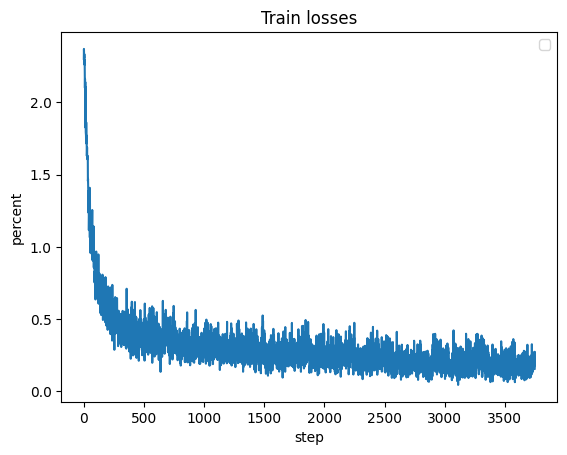

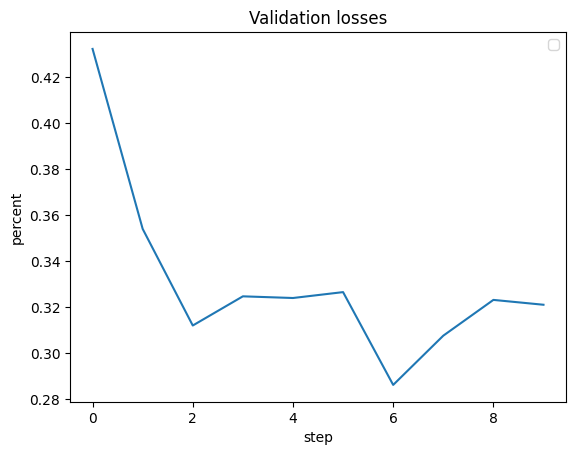

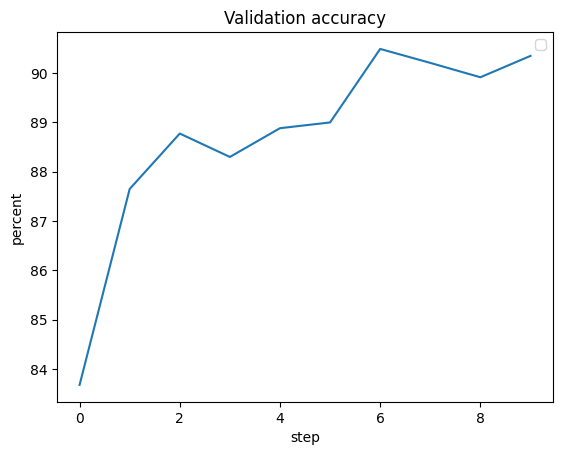

In [12]:
plt.figure()
plt.plot(train_losses)
plt.title('Train losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()


plt.figure()
plt.plot(validation_losses)
plt.title('Validation losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

plt.figure()
plt.plot(validation_accuracy)
plt.title('Validation accuracy')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

Accuracy per class:  [0.822 0.991 0.827 0.919 0.879 0.976 0.767 0.952 0.986 0.97 ]
Precision per class:  [0.86526316 0.991      0.87236287 0.90186457 0.84600577 0.97893681
 0.73608445 0.95774648 0.98501499 0.96039604]
Recall per class:  [0.822 0.991 0.827 0.919 0.879 0.976 0.767 0.952 0.986 0.97 ]
F1 per class:  [0.84307692 0.991      0.84907598 0.91035166 0.86218735 0.9774662
 0.75122429 0.95486459 0.98550725 0.96517413]


<Axes: >

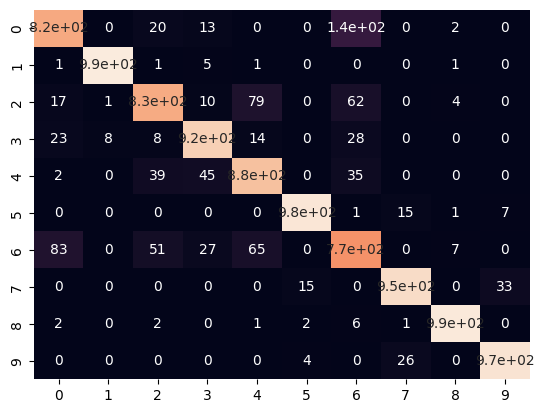

In [13]:
model.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

confusion = confusion_matrix(true_labels, predicted_labels)
total_samples_per_class = confusion.sum(axis=1)

print("Accuracy per class: ", confusion.diagonal()/total_samples_per_class)
print("Precision per class: ", precision_score(true_labels,  predicted_labels, average = None))
print("Recall per class: ", recall_score(true_labels,  predicted_labels, average = None))
print("F1 per class: ", f1_score(true_labels,  predicted_labels, average = None))

sns.heatmap(confusion, cbar = False, annot = True)

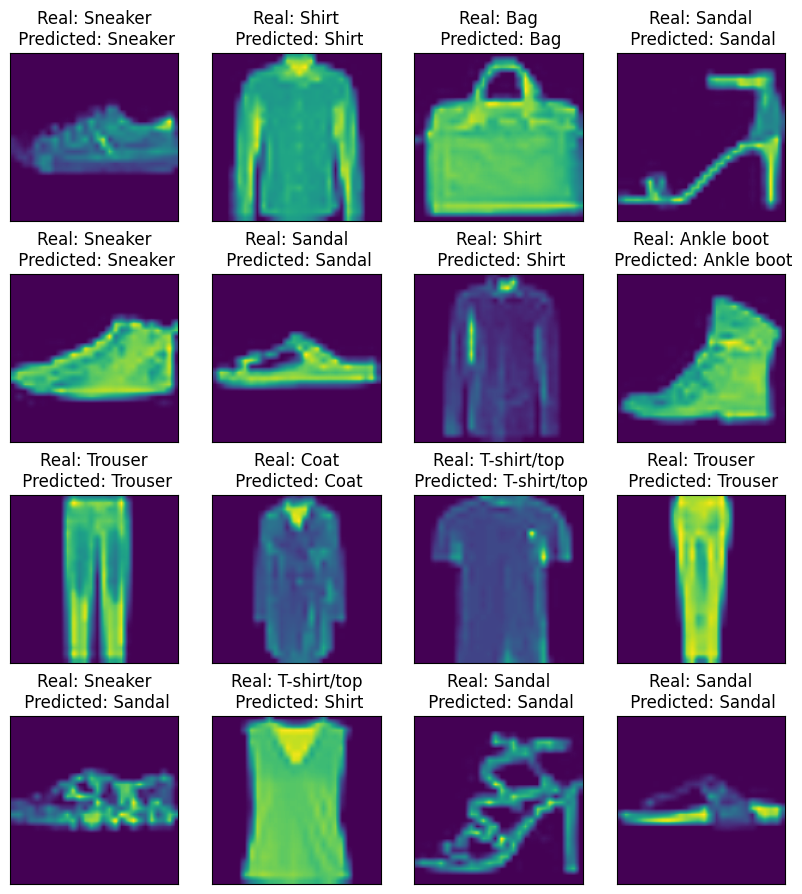

In [14]:
fig = plt.figure(figsize=(10, 11))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = np.transpose(np.array(images[i].to('cpu')), (1,2,0))
    plt.imshow(img/2 + 0.5)
    real_label = classes_labels[labels[i].item()]
    predicted_label = classes_labels[predicted[i].item()]
    ax.set_title(f"Real: {real_label}\n Predicted: {predicted_label}")

plt.show()

### Эксперимент 2
Обучение на 50% выборки

In [12]:
train_csv = pd.read_csv('data/fashion/fashion-mnist_train.csv')
test_dataset = pd.read_csv('data/fashion/fashion-mnist_test.csv')

train_csv = train_csv.sample(frac = 0.5)
test_dataset = test_dataset.sample(frac = 0.5)

train_dataset = train_csv.sample(frac = 0.8)
validation_dataset = train_csv.drop(train_dataset.index)

print(train_dataset.shape)
print(validation_dataset.shape)
print(test_dataset.shape)

(24000, 785)
(6000, 785)
(5000, 785)


In [13]:
train_loader = DataLoader(DatasetFashion(train_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(DatasetFashion(validation_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(DatasetFashion(test_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
criterion = F.nll_loss

In [14]:
feature_extr_model = Autoencoder().to(DEVICE)
feature_extr_criterion = nn.MSELoss()
feature_extr_optimizer = torch.optim.AdamW(feature_extr_model.parameters())

In [15]:
def train_encoder(train_loader, epoch, train_losses):
    feature_extr_model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        output = feature_extr_model(data)
        loss = feature_extr_criterion(output, data)
        feature_extr_optimizer.zero_grad()
        loss.backward()
        feature_extr_optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.9f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
def test_encoder(validation_loader, validation_losses):
    feature_extr_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (data, _) in validation_loader:
            data = data.to(DEVICE)
            output = feature_extr_model(data)
            test_loss += feature_extr_criterion(output, data).item()
            pred = output.max(1, keepdim=True)[1]

        test_loss /= len(validation_loader)  
        validation_losses.append(test_loss)
        print("Validation set: Average loss: {:.9f}\n".format(test_loss))
        print('='*50)

In [17]:
# Обучение энкодера на 50% данных

encoder_train_losses = []
encoder_validation_losses = []

for epoch in range(1, EPOCHS+1):
    train_encoder(train_loader, epoch, encoder_train_losses)
    test_encoder(validation_loader, encoder_validation_losses)

Epoch:1 [3712/24000 (15%)]	Loss: 0.044839233
Epoch:1 [7552/24000 (31%)]	Loss: 0.010407927
Epoch:1 [11392/24000 (47%)]	Loss: 0.006369167
Epoch:1 [15232/24000 (63%)]	Loss: 0.004846254
Epoch:1 [19072/24000 (79%)]	Loss: 0.003367382
Epoch:1 [22912/24000 (95%)]	Loss: 0.002737182
Validation set: Average loss: 0.002749146

Epoch:2 [3712/24000 (15%)]	Loss: 0.002060085
Epoch:2 [7552/24000 (31%)]	Loss: 0.002042960
Epoch:2 [11392/24000 (47%)]	Loss: 0.002236480
Epoch:2 [15232/24000 (63%)]	Loss: 0.001562150
Epoch:2 [19072/24000 (79%)]	Loss: 0.001311214
Epoch:2 [22912/24000 (95%)]	Loss: 0.001099728
Validation set: Average loss: 0.001065887

Epoch:3 [3712/24000 (15%)]	Loss: 0.001025201
Epoch:3 [7552/24000 (31%)]	Loss: 0.000883948
Epoch:3 [11392/24000 (47%)]	Loss: 0.000965373
Epoch:3 [15232/24000 (63%)]	Loss: 0.000857132
Epoch:3 [19072/24000 (79%)]	Loss: 0.000819833
Epoch:3 [22912/24000 (95%)]	Loss: 0.000750525
Validation set: Average loss: 0.000624895

Epoch:4 [3712/24000 (15%)]	Loss: 0.000579125
Epoc

In [18]:
encoder = feature_extr_model.encoder

In [19]:
def train(model, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [20]:
def test(model, validation_loader, validation_losses, validation_accuracy):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(validation_loader.dataset)  
        validation_losses.append(test_loss)
        validation_accuracy.append(100. * correct / len(validation_loader.dataset))
        print("Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(validation_loader.dataset), 100. * correct / len(validation_loader.dataset)))
        print('='*50)

In [21]:
train_losses = []
validation_losses = []
validation_accuracy = []

model = AlexNet(encoder).to(DEVICE)
for param in model.encoder.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.parameters())

for epoch in range(1, EPOCHS * 2 + 1):
    train(model, train_loader, optimizer, epoch, train_losses)
    test(model, validation_loader, validation_losses, validation_accuracy)

Epoch:1 [3712/24000 (15%)]	Loss: 1.406149
Epoch:1 [7552/24000 (31%)]	Loss: 1.033261
Epoch:1 [11392/24000 (47%)]	Loss: 0.638043
Epoch:1 [15232/24000 (63%)]	Loss: 1.172359
Epoch:1 [19072/24000 (79%)]	Loss: 0.599973
Epoch:1 [22912/24000 (95%)]	Loss: 0.471259
Validation set: Average loss: 0.6139, Accuracy: 4598/6000 (77%)

Epoch:2 [3712/24000 (15%)]	Loss: 0.385254
Epoch:2 [7552/24000 (31%)]	Loss: 0.623277
Epoch:2 [11392/24000 (47%)]	Loss: 0.492745
Epoch:2 [15232/24000 (63%)]	Loss: 0.514680
Epoch:2 [19072/24000 (79%)]	Loss: 0.401295
Epoch:2 [22912/24000 (95%)]	Loss: 0.613092
Validation set: Average loss: 0.4096, Accuracy: 5140/6000 (86%)

Epoch:3 [3712/24000 (15%)]	Loss: 0.278057
Epoch:3 [7552/24000 (31%)]	Loss: 0.439566
Epoch:3 [11392/24000 (47%)]	Loss: 0.201582
Epoch:3 [15232/24000 (63%)]	Loss: 0.313737
Epoch:3 [19072/24000 (79%)]	Loss: 0.325262
Epoch:3 [22912/24000 (95%)]	Loss: 0.300548
Validation set: Average loss: 0.3591, Accuracy: 5215/6000 (87%)

Epoch:4 [3712/24000 (15%)]	Loss: 0.27

In [22]:
torch.save(model.state_dict(), "./weights_model_50.pt")
torch.save(feature_extr_model.state_dict(), "./weights_extr_50.pt")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


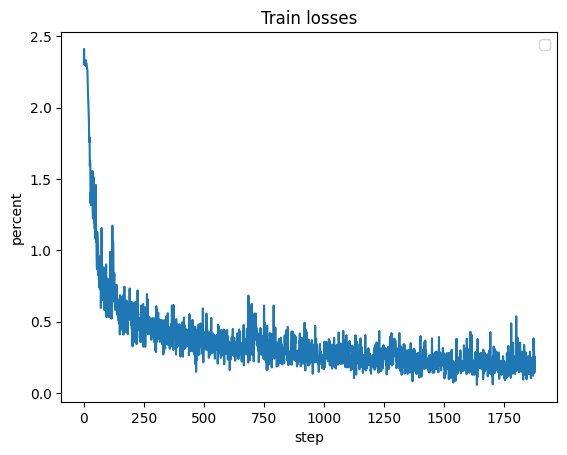

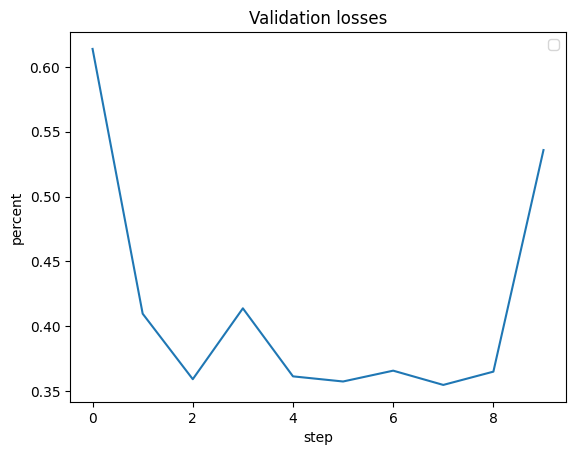

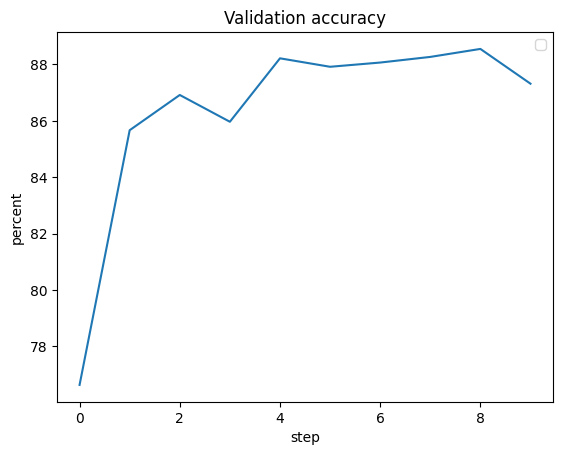

In [23]:
plt.figure()
plt.plot(train_losses)
plt.title('Train losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()


plt.figure()
plt.plot(validation_losses)
plt.title('Validation losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

plt.figure()
plt.plot(validation_accuracy)
plt.title('Validation accuracy')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

Accuracy per class:  [0.834      0.97137014 0.84909457 0.94444444 0.5851272  0.97302505
 0.70807453 0.98364008 0.98252427 0.92697769]
Precision per class:  [0.81604697 0.99580713 0.78293135 0.86545455 0.94321767 0.98249027
 0.58762887 0.9303675  0.95652174 0.98491379]
Recall per class:  [0.834      0.97137014 0.84909457 0.94444444 0.5851272  0.97302505
 0.70807453 0.98364008 0.98252427 0.92697769]
F1 per class:  [0.82492582 0.98343685 0.81467181 0.90322581 0.72222222 0.97773475
 0.64225352 0.95626243 0.96934866 0.95506792]


<Axes: >

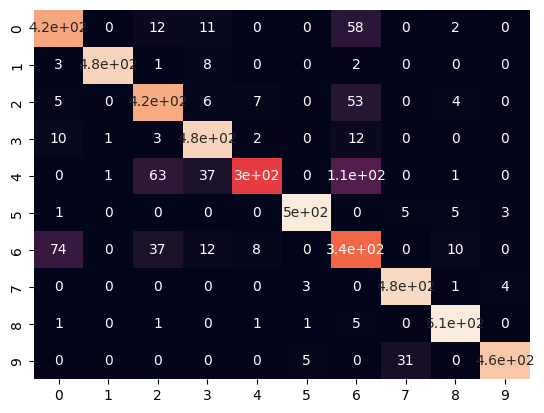

In [24]:
model.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

confusion = confusion_matrix(true_labels, predicted_labels)
total_samples_per_class = confusion.sum(axis=1)

print("Accuracy per class: ", confusion.diagonal()/total_samples_per_class)
print("Precision per class: ", precision_score(true_labels,  predicted_labels, average = None))
print("Recall per class: ", recall_score(true_labels,  predicted_labels, average = None))
print("F1 per class: ", f1_score(true_labels,  predicted_labels, average = None))

sns.heatmap(confusion, cbar = False, annot = True)

### Эксперимент 3

Обучение на 10% выборки

In [25]:
train_csv = pd.read_csv('data/fashion/fashion-mnist_train.csv')
test_dataset = pd.read_csv('data/fashion/fashion-mnist_test.csv')

train_csv = train_csv.sample(frac = 0.1)
test_dataset = test_dataset.sample(frac = 0.1)

train_dataset = train_csv.sample(frac = 0.8)
validation_dataset = train_csv.drop(train_dataset.index)

print(train_dataset.shape)
print(validation_dataset.shape)
print(test_dataset.shape)

(4800, 785)
(1200, 785)
(1000, 785)


In [26]:
train_loader = DataLoader(DatasetFashion(train_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(DatasetFashion(validation_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(DatasetFashion(test_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
criterion = F.nll_loss

In [27]:
feature_extr_model_3 = Autoencoder().to(DEVICE)
feature_extr_criterion_3 = nn.MSELoss()
feature_extr_optimizer_3 = torch.optim.AdamW(feature_extr_model_3.parameters())

In [28]:
def train_encoder(train_loader, epoch, train_losses):
    feature_extr_model_3.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        output = feature_extr_model_3(data)
        loss = feature_extr_criterion_3(output, data)
        feature_extr_optimizer_3.zero_grad()
        loss.backward()
        feature_extr_optimizer_3.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.9f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [29]:
def test_encoder(validation_loader, validation_losses):
    feature_extr_model_3.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (data, _) in validation_loader:
            data = data.to(DEVICE)
            output = feature_extr_model_3(data)
            test_loss += feature_extr_criterion_3(output, data).item()
            pred = output.max(1, keepdim=True)[1]

        test_loss /= len(validation_loader)  
        validation_losses.append(test_loss)
        print("Validation set: Average loss: {:.9f}\n".format(test_loss))
        print('='*50)

In [30]:
# Обучение энкодера на 50% данных

encoder_train_losses_3 = []
encoder_validation_losses_3 = []

for epoch in range(1, EPOCHS+1):
    train_encoder(train_loader, epoch, encoder_train_losses_3)
    test_encoder(validation_loader, encoder_validation_losses_3)

Epoch:1 [3712/4800 (76%)]	Loss: 0.056320939
Validation set: Average loss: 0.024494189

Epoch:2 [3712/4800 (76%)]	Loss: 0.012104509
Validation set: Average loss: 0.010760962

Epoch:3 [3712/4800 (76%)]	Loss: 0.006746908
Validation set: Average loss: 0.006405113

Epoch:4 [3712/4800 (76%)]	Loss: 0.004513116
Validation set: Average loss: 0.004557291

Epoch:5 [3712/4800 (76%)]	Loss: 0.004490621
Validation set: Average loss: 0.003603594



In [31]:
encoder_3 = feature_extr_model_3.encoder

In [32]:
def train(model, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [33]:
def test(model, validation_loader, validation_losses, validation_accuracy):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(validation_loader.dataset)  
        validation_losses.append(test_loss)
        validation_accuracy.append(100. * correct / len(validation_loader.dataset))
        print("Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(validation_loader.dataset), 100. * correct / len(validation_loader.dataset)))
        print('='*50)

In [34]:
train_losses_3 = []
validation_losses_3 = []
validation_accuracy_3 = []

model_3 = AlexNet(encoder_3).to(DEVICE)
for param in model_3.encoder.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model_3.parameters())

for epoch in range(1, EPOCHS * 2 + 1):
    train(model_3, train_loader, optimizer, epoch, train_losses_3)
    test(model_3, validation_loader, validation_losses_3, validation_accuracy_3)

Epoch:1 [3712/4800 (76%)]	Loss: 1.737651
Validation set: Average loss: 1.4522, Accuracy: 542/1200 (45%)

Epoch:2 [3712/4800 (76%)]	Loss: 0.883495
Validation set: Average loss: 0.9076, Accuracy: 772/1200 (64%)

Epoch:3 [3712/4800 (76%)]	Loss: 0.638217
Validation set: Average loss: 0.6274, Accuracy: 908/1200 (76%)

Epoch:4 [3712/4800 (76%)]	Loss: 0.696364
Validation set: Average loss: 0.6265, Accuracy: 915/1200 (76%)

Epoch:5 [3712/4800 (76%)]	Loss: 0.433666
Validation set: Average loss: 0.5243, Accuracy: 960/1200 (80%)

Epoch:6 [3712/4800 (76%)]	Loss: 0.563588
Validation set: Average loss: 0.4719, Accuracy: 989/1200 (82%)

Epoch:7 [3712/4800 (76%)]	Loss: 0.429712
Validation set: Average loss: 0.5345, Accuracy: 968/1200 (81%)

Epoch:8 [3712/4800 (76%)]	Loss: 0.440762
Validation set: Average loss: 0.4816, Accuracy: 976/1200 (81%)

Epoch:9 [3712/4800 (76%)]	Loss: 0.358792
Validation set: Average loss: 0.4932, Accuracy: 997/1200 (83%)

Epoch:10 [3712/4800 (76%)]	Loss: 0.295609
Validation se

In [35]:
torch.save(model_3.state_dict(), "./weights_model_10.pt")
torch.save(feature_extr_model_3.state_dict(), "./weights_extr_10.pt")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


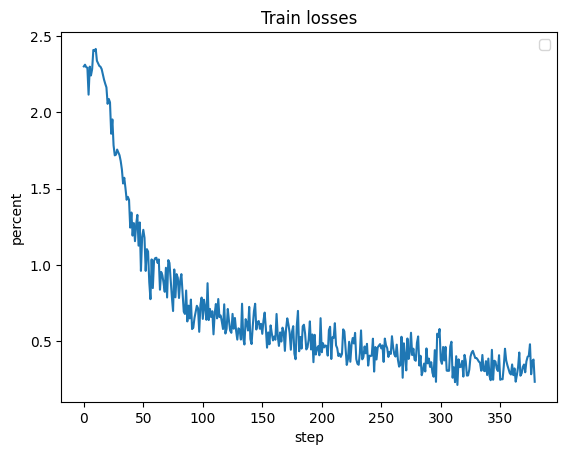

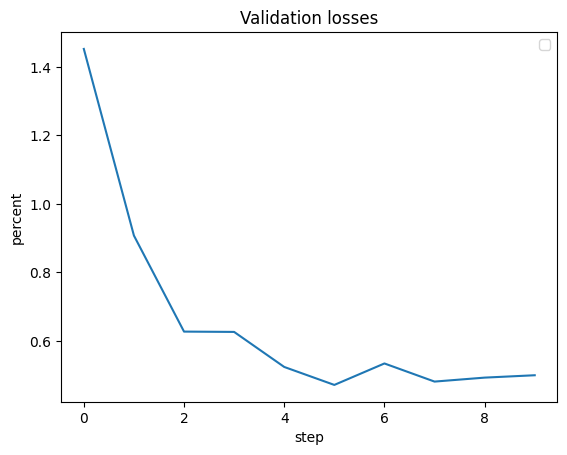

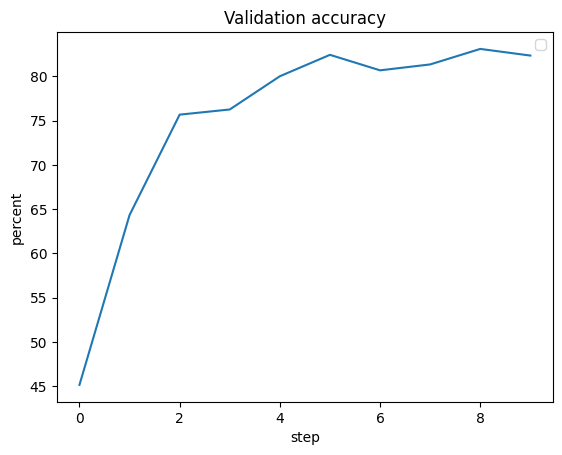

In [36]:
plt.figure()
plt.plot(train_losses_3)
plt.title('Train losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()


plt.figure()
plt.plot(validation_losses_3)
plt.title('Validation losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

plt.figure()
plt.plot(validation_accuracy_3)
plt.title('Validation accuracy')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

Accuracy per class:  [0.89534884 0.94186047 0.72916667 0.84482759 0.74107143 0.89565217
 0.36792453 0.95       0.96039604 0.92682927]
Precision per class:  [0.60629921 0.97590361 0.66666667 0.89090909 0.77570093 0.97169811
 0.52702703 0.89622642 0.97       0.92682927]
Recall per class:  [0.89534884 0.94186047 0.72916667 0.84482759 0.74107143 0.89565217
 0.36792453 0.95       0.96039604 0.92682927]
F1 per class:  [0.72300469 0.95857988 0.69651741 0.86725664 0.75799087 0.9321267
 0.43333333 0.9223301  0.96517413 0.92682927]


<Axes: >

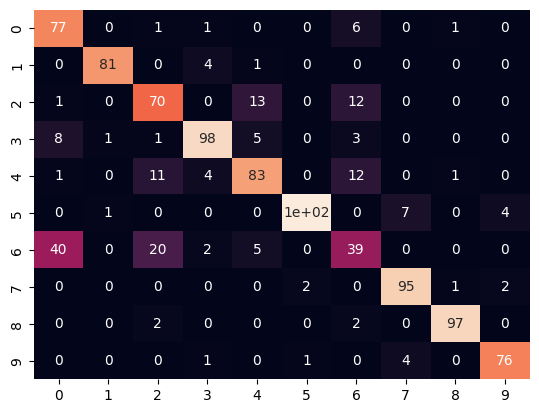

In [37]:
model_3.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_3(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

confusion = confusion_matrix(true_labels, predicted_labels)
total_samples_per_class = confusion.sum(axis=1)

print("Accuracy per class: ", confusion.diagonal()/total_samples_per_class)
print("Precision per class: ", precision_score(true_labels,  predicted_labels, average = None))
print("Recall per class: ", recall_score(true_labels,  predicted_labels, average = None))
print("F1 per class: ", f1_score(true_labels,  predicted_labels, average = None))

sns.heatmap(confusion, cbar = False, annot = True)